In [1]:
import pandas as pd
import os
import seaborn as sns

# Display settings
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 100)
print(os.getcwd())


/home/ant/CMPE256/Project/cmpe256_hotel_recommendation_system/src/notebooks


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load only the relevant columns
usecols = [
    'hotel_id', 'hotel_name', 'rating', 'sentiment_score',
    'sleep quality', 'value', 'rooms', 'cleanliness', 'location'
]
df = pd.read_csv('../../data/processed/hotelrec_cleaned.csv', usecols=usecols)

# Drop rows with missing values (or impute)
df.dropna(inplace=True)

# Normalize the numeric features (exclude hotel_id/name)
features = ['rating', 'sentiment_score', 'sleep quality', 'value', 'rooms', 'cleanliness', 'location']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

df['cluster'] = kmeans.fit_predict(X_scaled)

# Show a few examples
print(df[['hotel_id', 'hotel_name', 'cluster']].head())


    hotel_id               hotel_name  cluster
4    1121769             Hotel Baltic        2
5    1121769             Hotel Baltic        2
16   1735469  Pousada Rumo dos Ventos        2
17   1735469  Pousada Rumo dos Ventos        1
18   1735469  Pousada Rumo dos Ventos        1


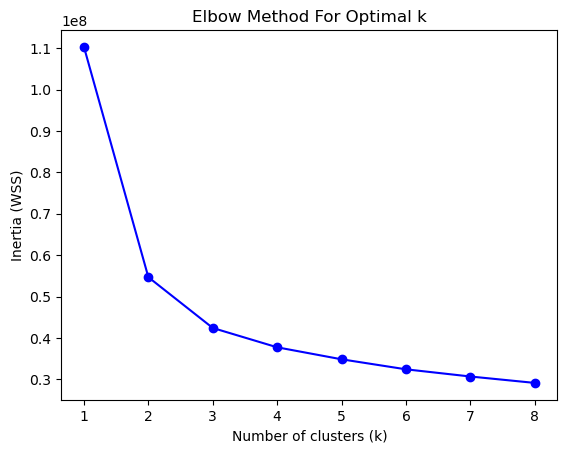

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assume X_scaled is your normalized feature matrix

inertias = []
K = range(1, 9)  # Test from 1 to 8 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    
# Plot Inertia (Elbow method)
plt.figure()
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WSS)')
plt.title('Elbow Method For Optimal k')
plt.show()




In [4]:
# 1. Load only user reviews in manageable size (sampled if needed)
user_reviews = pd.read_csv('../../data/processed/hotelrec_cleaned.csv', 
                           usecols=['author', 'hotel_id', 'rating'])

# 2. Merge hotel cluster info into user reviews
hotel_clusters = df[['hotel_id', 'cluster']]

user_reviews = user_reviews.merge(hotel_clusters, on='hotel_id', how='inner')

# 3. Now user_reviews has (author, hotel_id, rating, cluster)


MemoryError: Unable to allocate 129. GiB for an array with shape (17380456625,) and data type int64

In [ ]:
import pandas as pd
from tqdm import tqdm
import os

chunk_size = 20_000

reader = pd.read_csv('../../data/processed/hotelrec_cleaned.csv', 
                     usecols=['author', 'hotel_id', 'rating'], 
                     chunksize=chunk_size)

# Output folder for Parquet chunks
output_folder = '../../data/processed/user_reviews_parquet_chunks/'
os.makedirs(output_folder, exist_ok=True)

chunk_idx = 0

for user_reviews_chunk in tqdm(reader, desc="Merging and saving to Parquet"):
    merged_chunk = user_reviews_chunk.merge(hotel_clusters, on='hotel_id', how='left')
    
    output_path = os.path.join(output_folder, f"user_reviews_chunk_{chunk_idx}.parquet")
    
    # Save each merged chunk directly to a separate Parquet file
    merged_chunk.to_parquet(output_path, index=False)
    
    chunk_idx += 1

print("✅ All chunks saved as Parquet files.")



Merging and saving to Parquet: 334it [08:53,  3.85s/it]

In [ ]:
import pandas as pd
from tqdm import tqdm

chunk_size = 10_000

reader = pd.read_csv('../../data/processed/hotelrec_cleaned.csv', 
                     usecols=['author', 'hotel_id', 'rating'], 
                     chunksize=chunk_size)

output_file = '../../data/processed/user_reviews_with_clusters.csv'
first_chunk = True

# Use tqdm to wrap the reader
for user_reviews_chunk in tqdm(reader, desc="Processing chunks"):
    merged_chunk = user_reviews_chunk.merge(hotel_clusters, on='hotel_id', how='left')
    
    # Save immediately
    if first_chunk:
        merged_chunk.to_csv(output_file, index=False, mode='w')  # write header
        first_chunk = False
    else:
        merged_chunk.to_csv(output_file, index=False, mode='a', header=False)  # append without header


Processing chunks: 5027it [7:27:13,  5.34s/it] 
